In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import random
import math
import time

import numpy as np
np.random.seed(1)
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
#%matplotlib notebook

from numpy.linalg import inv
from numpy import linalg as LA
from scipy import linalg
import random


Using TensorFlow backend.


In [2]:
def scale_training_data(X_train, Y_train):
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
    
    X_train_s = x_scaler.fit_transform(X_train)
    Y_train_s = y_scaler.fit_transform(Y_train)
    
    return X_train_s, Y_train_s, x_scaler, y_scaler

In [3]:
def train_test_split(X_train, Y_train, train_portion):

    x_train = X_train[0:int(n_timesteps*train_portion),:]
    x_test = X_train[int(n_timesteps*(train_portion)):,:]
    y_train = Y_train[0:int(n_timesteps*train_portion),:]
    y_test = Y_train[int(n_timesteps*(train_portion)):,:]
    
    return x_train, y_train, x_test, y_test

In [4]:
def baseline_model(input_dim, output_dim, height):
    model = Sequential()
    model.add(Dense(height, input_dim=input_dim, activation='tanh', kernel_initializer='normal'))
    model.add(Dense(height, input_dim=height, activation='tanh', kernel_initializer='normal'))
    #model.add(Dense(height, input_dim=height, activation='tanh', kernel_initializer='normal'))
    model.add(Dense(output_dim, input_dim=height, activation='linear', kernel_initializer='normal'))
    adam = Adam(lr=0.0001)
    model.compile(loss='mae', optimizer=adam)
    
    earlystop = EarlyStopping(monitor='loss', min_delta=0.000001, patience=10, verbose=1, mode='auto')
    callback_list = [earlystop]
    return model, callback_list

In [5]:
def prepare_training_data(df_F, df_D, df_Dt, d, t):

    D = df_D.values
    Dt = df_Dt.values
    F = df_F.values
    dim = np.shape(D)

    n_timesteps, n_nodes = dim
    x = np.linspace(0,1, n_nodes)

    X_train = np.zeros([n_timesteps-d, 3*d*n_nodes])
    Y_train = np.zeros([n_timesteps-d, 2*n_nodes])


    for k in range(n_timesteps-d):

        bulk = 0
        for j in range(n_nodes):
            X_train[k, bulk:bulk + d] = F[t-d:t,j]    
            bulk += d

        for j in range(n_nodes):
            X_train[k, bulk:bulk + d] = D[t-d:t,j]
            bulk += d

        for j in range(n_nodes):
            X_train[k, bulk: bulk + d] = Dt[t-d:t,j]
            bulk += d

        Y_train[k, 0:n_nodes] = D[t, :]
        Y_train[k, n_nodes:] = Dt[t, :]
        t += 1
        
    return X_train, Y_train, n_timesteps, n_nodes, x

In [6]:
def get_error(predictions, y_test):
    error = 0
    for i in range(len(predictions[:,0])):
        error += np.trapz((y_test[i,:] - predictions[i,:])**2, x)
    return error

In [7]:
def independent_predictions(x_test):

    input_i = np.copy(x_test[0,:])

    dz = np.copy(input_i[d*n_nodes:])

    dz = np.reshape(dz, (n_nodes*2, d))


    #dzt = np.copy(input_i[d+1+n_nodes*d:])
    #dzt = np.reshape(dzt, (n_nodes, d))

    preds = np.zeros([len(x_test[:,0])-1, n_nodes*2])
    force = np.copy(x_test[:, 0:d*n_nodes])

    for k in range(len(x_test[:,0])-1):


        pred = model.predict(np.reshape(input_i,(1,len(input_i))))
        preds[k, :] = pred

        input_i[0:d*n_nodes] = force[k+1,:]

        dz = np.delete(dz, 0, 1)
        dz = np.concatenate((dz, np.reshape(pred[0,:], (1,n_nodes*2)).T), axis=1)
        #dz[0,:] = np.zeros(d)
        #dzt = np.delete(dzt, 0, 1)
        #dzt = np.concatenate((dzt, np.reshape(pred[0,n_nodes:], (1, n_nodes)).T), axis=1)
        #dzt[0,:] = np.zeros(n_nodes)
        input_i[d*n_nodes:] = np.reshape(dz, (1, n_nodes*d*2))[0]
        #input_i[d+1+n_nodes*d:] = np.reshape(dzt, (1, n_nodes*d))[0]
    
    return preds


In [11]:
########################### TRAIN FEED-FORWARD MODEL #################################

d = 10 #number of steps in "model memory"
t = d
n_batches = 1

t0 = time.time()
for i in range(n_batches):

    df_D = pd.read_csv('../training_batches/D' + str(i+1) + '.csv')
    df_F = pd.read_csv('../training_batches/F' + str(i+1) + '.csv')
    df_Dt = pd.read_csv('../training_batches/Dt' + str(i+1) + '.csv')
    
    X_train, Y_train, n_timesteps, n_nodes, x = prepare_training_data(df_F, df_D, df_Dt, d, t)
    
    X_train_s, Y_train_s, x_scaler, y_scaler = scale_training_data(X_train, Y_train)
    
    x_train, y_train, x_test, y_test = train_test_split(X_train_s, Y_train_s, 0.8)
    
    input_dim = len(X_train[0,:])
    output_dim = len(Y_train[0,:])

    if i == 0:
        model, callback_list = baseline_model(input_dim, output_dim, 100)
    
    ts = time.time()
    model.fit(x_train, y_train, epochs=500,verbose = 1, callbacks=None)
    training_time = time.time() - ts
    
    pred_train_all = model.predict(x_train)
    pred_train = pred_train_all[:, 0:n_nodes]
    pred_train_u = y_scaler.inverse_transform(pred_train_all)[:, 0:n_nodes]
    
    pred_test_all = model.predict(x_test)
    pred_test = pred_test_all[:, 0:n_nodes]
    pred_test_u = y_scaler.inverse_transform(pred_test_all)[:, 0:n_nodes]
    
    pred_ind_all = independent_predictions(x_test)
    pred_ind = pred_ind_all[:, 0:n_nodes]
    pred_ind_u = y_scaler.inverse_transform(pred_ind_all)[:, 0:n_nodes]
    
    y_test_u = y_scaler.inverse_transform(y_test)
    
    training_error = get_error(pred_train, y_train[:,0:n_nodes])
    test_error = get_error(pred_test, y_test[:,0:n_nodes])
    ind_error = get_error(pred_ind, y_test[0:len(pred_ind[:,0]),0:n_nodes])
    
    total_time = time.time() - t0
    
    info = {'Iteration': i, 'Train error': training_error, 'Test error': test_error, 'Independent error': ind_error,
            'Training time': training_time, 'Total time': total_time}
    
    print(info)
    

Epoch 1/500
24000/24000 [==============================] - 2s 102us/step - loss: 0.0444
Epoch 2/500
24000/24000 [==============================] - 2s 79us/step - loss: 0.0095
Epoch 3/500
24000/24000 [==============================] - 2s 77us/step - loss: 0.0079
Epoch 4/500
24000/24000 [==============================] - 2s 75us/step - loss: 0.0069
Epoch 5/500
24000/24000 [==============================] - 2s 87us/step - loss: 0.0061
Epoch 6/500
24000/24000 [==============================] - 2s 86us/step - loss: 0.0058
Epoch 7/500
24000/24000 [==============================] - 2s 91us/step - loss: 0.0055
Epoch 8/500
24000/24000 [==============================] - 2s 88us/step - loss: 0.0053
Epoch 9/500
24000/24000 [==============================] - 2s 89us/step - loss: 0.0054
Epoch 10/500
24000/24000 [==============================] - 2s 89us/step - loss: 0.0047
Epoch 11/500
24000/24000 [==============================] - 2s 89us/step - loss: 0.0048
Epoch 12/500
24000/24000 [==============

Epoch 185/500
24000/24000 [==============================] - 2s 75us/step - loss: 0.0031
Epoch 186/500
24000/24000 [==============================] - 2s 73us/step - loss: 0.0034
Epoch 187/500
24000/24000 [==============================] - 2s 75us/step - loss: 0.0031
Epoch 188/500
24000/24000 [==============================] - 2s 74us/step - loss: 0.0033
Epoch 189/500
24000/24000 [==============================] - 2s 73us/step - loss: 0.0030
Epoch 190/500
24000/24000 [==============================] - 2s 74us/step - loss: 0.0033
Epoch 191/500
24000/24000 [==============================] - 2s 73us/step - loss: 0.0032
Epoch 192/500
24000/24000 [==============================] - 2s 74us/step - loss: 0.0032
Epoch 193/500
24000/24000 [==============================] - 2s 74us/step - loss: 0.0035
Epoch 194/500
24000/24000 [==============================] - 2s 74us/step - loss: 0.0032
Epoch 195/500
24000/24000 [==============================] - 2s 75us/step - loss: 0.0033
Epoch 196/500
24000/2

Epoch 277/500
24000/24000 [==============================] - 2s 64us/step - loss: 0.0026
Epoch 278/500
24000/24000 [==============================] - 2s 63us/step - loss: 0.0025
Epoch 279/500
24000/24000 [==============================] - 2s 64us/step - loss: 0.0023
Epoch 280/500
24000/24000 [==============================] - 2s 64us/step - loss: 0.0023
Epoch 281/500
24000/24000 [==============================] - 2s 63us/step - loss: 0.0026
Epoch 282/500
24000/24000 [==============================] - 2s 64us/step - loss: 0.0022
Epoch 283/500
24000/24000 [==============================] - 2s 63us/step - loss: 0.0022
Epoch 284/500
24000/24000 [==============================] - 2s 64us/step - loss: 0.0025
Epoch 285/500
24000/24000 [==============================] - 2s 63us/step - loss: 0.0024
Epoch 286/500
24000/24000 [==============================] - 2s 64us/step - loss: 0.0024
Epoch 287/500
24000/24000 [==============================] - 2s 64us/step - loss: 0.0025
Epoch 288/500
24000/2

24000/24000 [==============================] - 2s 75us/step - loss: 0.0018
Epoch 370/500
24000/24000 [==============================] - 2s 76us/step - loss: 0.0020
Epoch 371/500
24000/24000 [==============================] - 2s 74us/step - loss: 0.0018
Epoch 372/500
24000/24000 [==============================] - 2s 74us/step - loss: 0.0016
Epoch 373/500
24000/24000 [==============================] - 2s 78us/step - loss: 0.0020
Epoch 374/500
24000/24000 [==============================] - 2s 76us/step - loss: 0.0017
Epoch 375/500
24000/24000 [==============================] - 2s 74us/step - loss: 0.0019
Epoch 376/500
24000/24000 [==============================] - 2s 75us/step - loss: 0.0017
Epoch 377/500
24000/24000 [==============================] - 2s 74us/step - loss: 0.0019
Epoch 378/500
24000/24000 [==============================] - 2s 75us/step - loss: 0.0018
Epoch 379/500
24000/24000 [==============================] - 2s 80us/step - loss: 0.0018
Epoch 380/500
24000/24000 [========

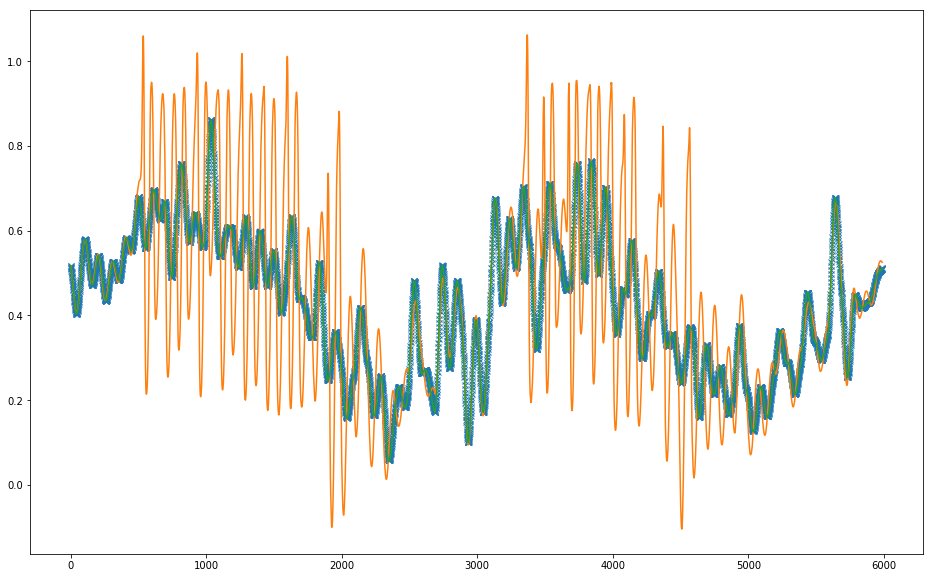

{'Iteration': 1, 'Train error': 0.016533734210497256, 'Test error': 0.0025669965123102331, 'Independent error': 212.23342177541787, 'Training time': 0.0, 'Total time': 6.0500099658966064}


In [12]:
######################## TEST FEED-FORWARD MODEL ###########################

t0 = time.time()

for iteration in range(n_batches):

    df_D = pd.read_csv('../training_batches/D' + str(iteration+1) + '.csv')
    df_F = pd.read_csv('../training_batches/F' + str(iteration+1) + '.csv')
    df_Dt = pd.read_csv('../training_batches/Dt' + str(iteration+1) + '.csv')
    
    X_train, Y_train, n_timesteps, n_nodes, x = prepare_training_data(df_F, df_D, df_Dt, d, t)
    
    X_train_s, Y_train_s, x_scaler, y_scaler = scale_training_data(X_train, Y_train)
    
    x_train, y_train, x_test, y_test = train_test_split(X_train_s, Y_train_s, 0.8)
    
    input_dim = len(X_train[0,:])
    output_dim = len(Y_train[0,:])

    #if i == 0:
    #    model = baseline_model(input_dim, output_dim, 100)
    
    ts = time.time()
    #model.fit(x_train, y_train, epochs=100, verbose = 1)
    training_time = time.time() - ts
    
    pred_train_all = model.predict(x_train)
    pred_train = pred_train_all[:, 0:n_nodes]
    pred_train_u = y_scaler.inverse_transform(pred_train_all)[:, 0:n_nodes]
    
    pred_test_all = model.predict(x_test)
    pred_test = pred_test_all[:, 0:n_nodes]
    pred_test_u = y_scaler.inverse_transform(pred_test_all)[:, 0:n_nodes]
    
    pred_ind_all = independent_predictions(x_test)
    pred_ind = pred_ind_all[:, 0:n_nodes]
    pred_ind_u = y_scaler.inverse_transform(pred_ind_all)[:, 0:n_nodes]
    
    y_test_u = y_scaler.inverse_transform(y_test)[:, 0:n_nodes]
    
    training_error = get_error(pred_train, y_train[:,0:n_nodes])
    test_error = get_error(pred_test, y_test[:,0:n_nodes])
    ind_error = get_error(pred_ind, y_test[0:len(pred_ind[:,0]),0:n_nodes])
    
    plt.figure(figsize=(16,10))
    plt.plot(pred_test[:,n_nodes-1], 'x')
    plt.plot(pred_ind[:,n_nodes-1])
    plt.plot(y_test[:, n_nodes-1])
    plt.show()
    
    total_time = time.time() - t0
    
    info = {'Iteration': iteration+1, 'Train error': training_error, 'Test error': test_error, 'Independent error': ind_error,
            'Training time': training_time, 'Total time': total_time}
    
    print(info)

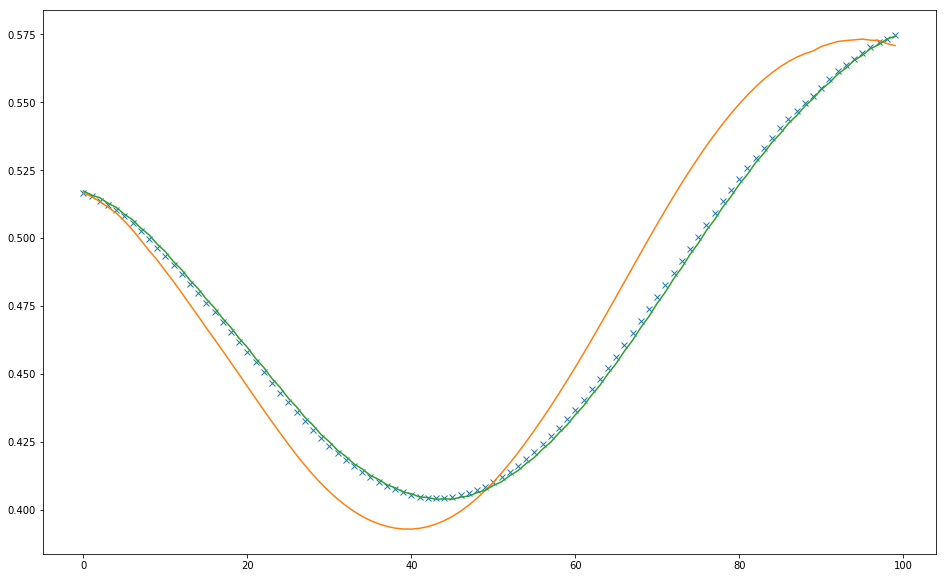

In [15]:
plt.figure(figsize=(16,10))
plt.plot(pred_test[:100,n_nodes-1], 'x')
plt.plot(pred_ind[:100,n_nodes-1])
plt.plot(y_test[0:100, n_nodes-1])
plt.show()

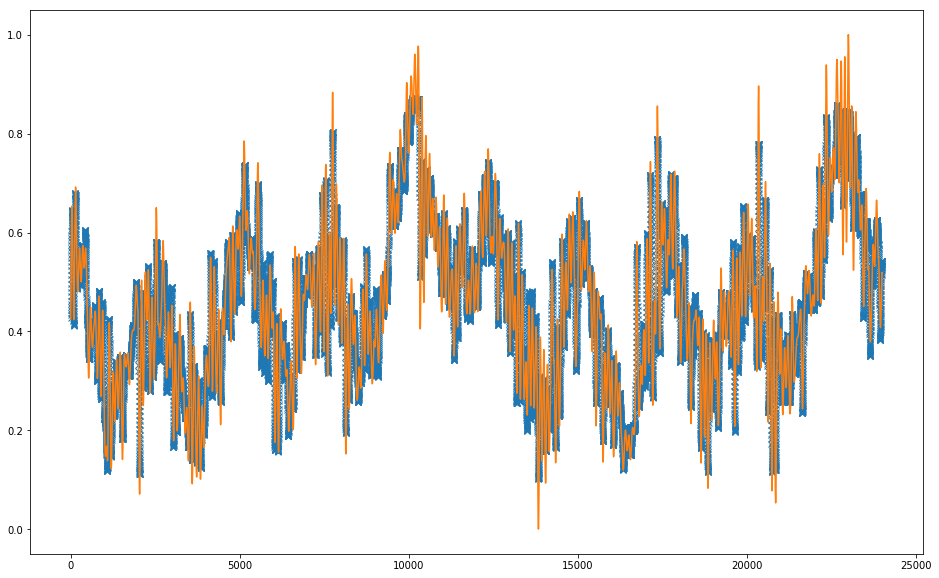

In [19]:
ind_pred_train = independent_predictions(x_train)[:,:n_nodes]
plt.figure(figsize=(16,10))
plt.plot(ind_pred_train[:,n_nodes-1], 'x')
plt.plot(y_train[:, n_nodes-1])
plt.show()

In [16]:
#Export results
np.savetxt("../results/predictions.csv", pred_test_u, delimiter=",")
np.savetxt("../results/preds.csv", pred_ind_u, delimiter=",")
np.savetxt("../results/y_test.csv", y_test_u, delimiter=",")
np.savetxt("../results/y_train.csv", y_test_u, delimiter=",")